IMPORTS

In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import folium
import folium.plugins as plugins

import scipy.stats as stats

LOAD DATA

In [69]:
full_fires_df = pd.read_csv('/Users/kaciewebster/Documents/dsi/ca-fire-incidents/California_Fire_Incidents.csv')
full_fires_df.head(1)

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,...,SearchKeywords,Started,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders
0,257314.0,False,Stanislaus National Forest/Yosemite National Park,NaN,2013,True,/incidents/2013/8/17/rim-fire/,NaN,NaN,Tuolumne,...,"Rim Fire, Stanislaus National Forest, Yosemite...",2013-08-17T15:25:00Z,Finalized,NaN,NaN,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,2013-09-06T18:30:00Z,NaN


In [70]:
full_fires_df.shape

(1636, 40)

In [71]:
full_fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AcresBurned           1633 non-null   float64
 1   Active                1636 non-null   bool   
 2   AdminUnit             1636 non-null   object 
 3   AirTankers            28 non-null     float64
 4   ArchiveYear           1636 non-null   int64  
 5   CalFireIncident       1636 non-null   bool   
 6   CanonicalUrl          1636 non-null   object 
 7   ConditionStatement    284 non-null    object 
 8   ControlStatement      111 non-null    object 
 9   Counties              1636 non-null   object 
 10  CountyIds             1636 non-null   object 
 11  CrewsInvolved         171 non-null    float64
 12  Dozers                123 non-null    float64
 13  Engines               191 non-null    float64
 14  Extinguished          1577 non-null   object 
 15  Fatalities           

DATA CLEANING

In [72]:
full_fires_df['StartDate'] = full_fires_df['Started'].apply(lambda x: pd.to_datetime(x[:10]))
# creates a date column for when the fire started.
full_fires_df['StartYear'] = full_fires_df['Started'].apply(lambda x: int(x[:4]))
# creates a year column for when the fire started.
full_fires_df['StartMonth'] = full_fires_df['Started'].apply(lambda x: int(x[5:7]))
# creates a month column for when the fire started.

In [73]:
ca_fires_df = full_fires_df[['UniqueId', 'Name', 'Counties', 'StartYear', 'StartMonth', 'StartDate', 'AcresBurned', 'Latitude', 'Longitude', 'MajorIncident']]
ca_fires_df.shape
# creates dataframe that I will work out of.

(1636, 10)

In [74]:
ca_fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UniqueId       1636 non-null   object        
 1   Name           1636 non-null   object        
 2   Counties       1636 non-null   object        
 3   StartYear      1636 non-null   int64         
 4   StartMonth     1636 non-null   int64         
 5   StartDate      1636 non-null   datetime64[ns]
 6   AcresBurned    1633 non-null   float64       
 7   Latitude       1636 non-null   float64       
 8   Longitude      1636 non-null   float64       
 9   MajorIncident  1636 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 116.8+ KB


In [75]:
ca_fires_df = ca_fires_df.dropna(axis=0, subset=['AcresBurned'])
ca_fires_df = ca_fires_df[ca_fires_df['AcresBurned'] != 0]
ca_fires_df.shape
# removes zeros and null values from AcresBurned column.

(1605, 10)

In [76]:
ca_fires_df = ca_fires_df[(ca_fires_df['Latitude'] >= 32) & (ca_fires_df['Latitude'] <= 42) & (ca_fires_df['Longitude'] <= -114) & (ca_fires_df['Longitude'] >= -126)]
ca_fires_df.shape
# removes observations that are not in CA.

(1439, 10)

In [77]:
ca_fires_df[(ca_fires_df['Latitude'] >= 38) & (ca_fires_df['Latitude'] <= 41) & (ca_fires_df['Longitude'] <= -115) & (ca_fires_df['Longitude'] >= -118)]
ca_fires_df[ca_fires_df['Counties'] == 'State of Nevada']
# locates which observations were falling in Nevada.

,UniqueId,Name,Counties,StartYear,StartMonth,StartDate,AcresBurned,Latitude,Longitude,MajorIncident
1424,3086ac2b-bbb3-4321-81e3-3cfdb9e571e9,Jasper Fire,State of Nevada,2019,7,2019-07-13,1165.0,39.631945,-119.769881,False


In [78]:
ca_fires_df = ca_fires_df[ca_fires_df['Counties'] != 'State of Nevada']
ca_fires_df = ca_fires_df[ca_fires_df['Name'] != 'Tram Fire']
ca_fires_df.shape
# removes observations that are in Nevada.

(1437, 10)

In [79]:
ca_fires_df = ca_fires_df[ca_fires_df['StartYear'] >= 2013]
ca_fires_df.shape
# removes observations that are not in the years 2013-2019.

(1435, 10)

In [80]:
ca_fires_df['UniqueId'].nunique()
# returns number of unique fires.

1410

In [81]:
ca_fires_df = ca_fires_df.groupby('UniqueId').max().reset_index()
ca_fires_df.shape
# removes duplicate records of fires.

(1410, 10)

In [82]:
ca_fires_df.head(1)

,UniqueId,Name,Counties,StartYear,StartMonth,StartDate,AcresBurned,Latitude,Longitude,MajorIncident
0,00089805-cdee-4607-8b67-1653bee463bc,Gulch Fire,Modoc,2014,7,2014-07-03,1469.0,41.489,-120.904,True


In [83]:
ca_fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UniqueId       1410 non-null   object        
 1   Name           1410 non-null   object        
 2   Counties       1410 non-null   object        
 3   StartYear      1410 non-null   int64         
 4   StartMonth     1410 non-null   int64         
 5   StartDate      1410 non-null   datetime64[ns]
 6   AcresBurned    1410 non-null   float64       
 7   Latitude       1410 non-null   float64       
 8   Longitude      1410 non-null   float64       
 9   MajorIncident  1410 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 100.6+ KB


In [84]:
ca_fires_df.describe()

,StartYear,StartMonth,AcresBurned,Latitude,Longitude
count,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000
mean,2016.807801,7.400709,3247.733333,37.223930,-120.274294
std,1.803497,1.749906,19507.818882,2.551992,2.003783
min,2013.000000,1.000000,2.000000,32.557546,-124.196290
25%,2016.000000,6.000000,35.250000,34.906157,-121.848938
50%,2017.000000,7.000000,100.000000,37.414110,-120.695931
75%,2018.000000,9.000000,400.000000,39.246458,-118.731552
max,2019.000000,12.000000,410203.000000,41.999341,-114.572650


EXPLORATORY DATA ANALYSIS

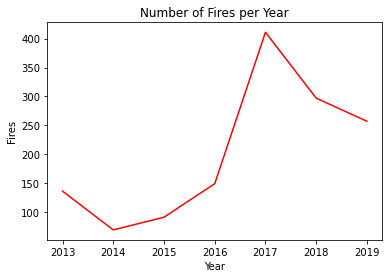

In [85]:
num_fires = ca_fires_df.groupby('StartYear')['AcresBurned'].count()
years = sorted(ca_fires_df['StartYear'].unique())

fig, ax = plt.subplots()
ax.plot(years, num_fires, color='red')
ax.set_title('Number of Fires per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Fires')

plt.show()

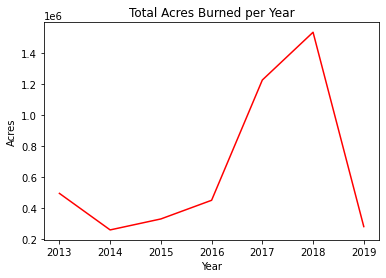

In [86]:
sum_acres = ca_fires_df.groupby('StartYear')['AcresBurned'].sum()
years = sorted(ca_fires_df['StartYear'].unique())

fig, ax = plt.subplots()
ax.plot(years, sum_acres, color='red')
ax.set_title('Total Acres Burned per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Acres')

plt.show()

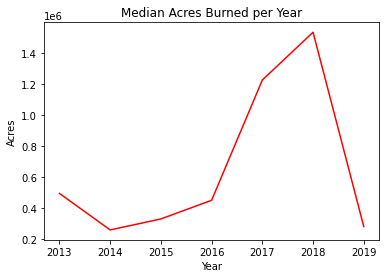

In [87]:
median_acres = ca_fires_df.groupby('StartYear')['AcresBurned'].median()
years = sorted(ca_fires_df['StartYear'].unique())

fig, ax = plt.subplots()
ax.plot(years, sum_acres, color='red')
ax.set_title('Median Acres Burned per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Acres')

plt.show()

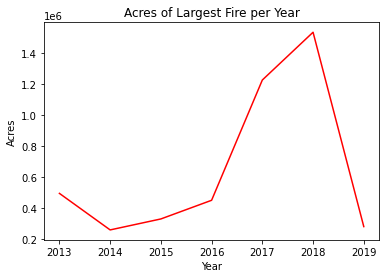

In [88]:
max_acres = ca_fires_df.groupby('StartYear')['AcresBurned'].max()
years = sorted(ca_fires_df['StartYear'].unique())

fig, ax = plt.subplots()
ax.plot(years, sum_acres, color='red')
ax.set_title('Acres of Largest Fire per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Acres')

plt.show()

In [89]:
df_copy = ca_fires_df.copy()
df_years_list = []
for year in df_copy['StartYear'].sort_values().unique():
    df_years_list.append(df_copy.loc[df_copy['StartYear']==year, ['Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())
# creates a list of lists where each element is a year and each element in that list element contains the latitudes and longitudes of each fire.
    
m = folium.Map(location=[34.0522, -118.2437], zoom_start=5)
plugins.HeatMapWithTime(df_years_list, radius=5, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(m)
m

In [90]:
grouped_acres_sum = ca_fires_df.groupby(['StartYear', 'StartMonth']).sum('AcresBurned')['AcresBurned'].reset_index()
grouped_acres_sum

,StartYear,StartMonth,AcresBurned
0,2013,2,406.0
1,2013,4,379.0
2,2013,5,53957.0
3,2013,6,5127.0
4,2013,7,77082.0
...,...,...,...
59,2019,7,20463.0
60,2019,8,15129.0
61,2019,9,101251.0
62,2019,10,119814.0


In [91]:
def parse_grouped_sums(grouped_df, year_lst):
    '''
    Creates a list of dataframes parsed by year.
    Parameters: grouped dataframe, list of years
    Returns: list of dataframes
    '''
    parse_lst = []
    
    for year in year_lst:
        parse_lst.append(grouped_df[grouped_df['StartYear']==year])
    return parse_lst 

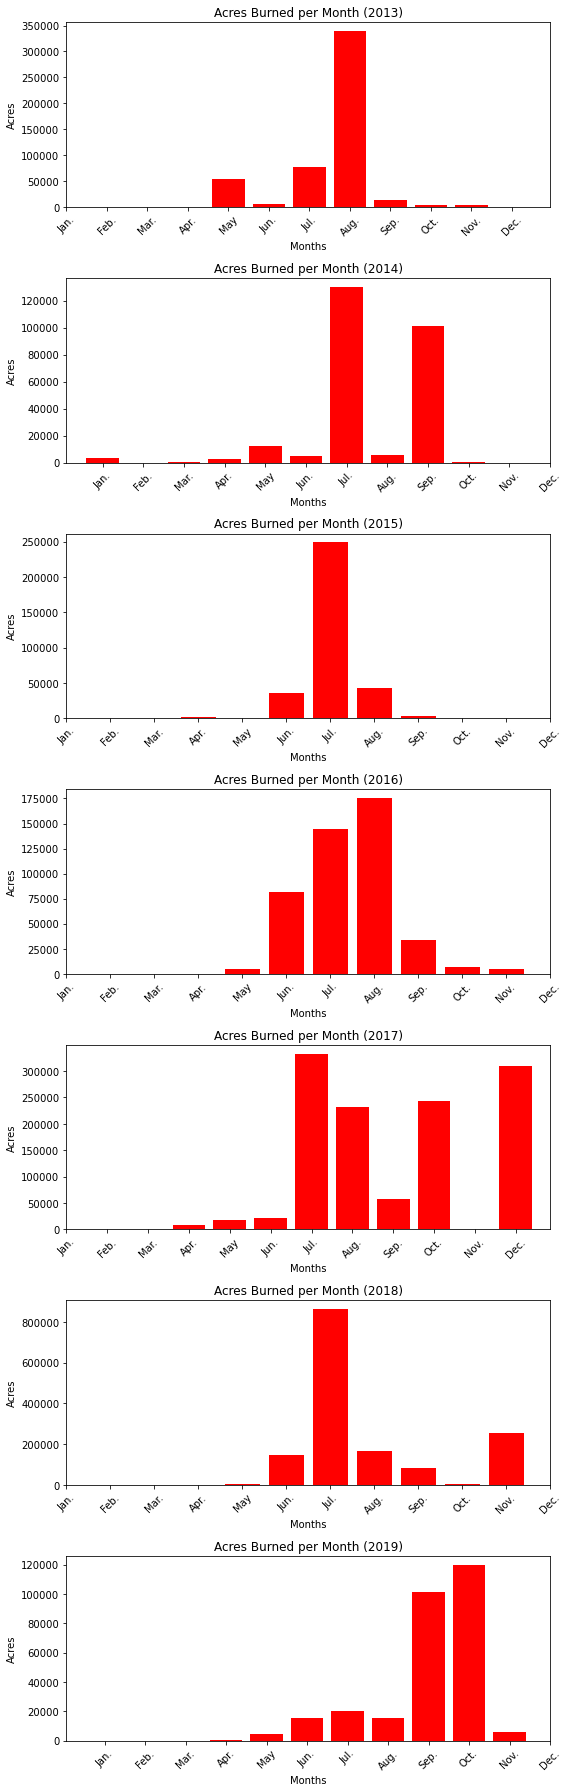

In [92]:
year_lst = list(range(2013, 2020))
df_lst = parse_grouped_sums(grouped_acres_sum, year_lst)

month_labels = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.']
fig, axs = plt.subplots(7, 1, figsize=(8, 25))

for idx, ax in enumerate(axs.flatten()):
    ax.bar(df_lst[idx]['StartMonth'], height=df_lst[idx]['AcresBurned'], color='red')
        
    ax.set_xticks(list(range(1, 13)))
    ax.set_xticklabels(month_labels, rotation=45)
        
    ax.set_title(f'Acres Burned per Month ({year_lst[idx]})')
    ax.set_xlabel('Months')
    ax.set_ylabel('Acres')

fig.tight_layout()
plt.show()

HYPOTHESIS TEST

H0: There is no trend for the number of acres burned by the California Fires over the years 2013-2019.
H1: The number of acres burned by the California Fires has been increasing over the years.

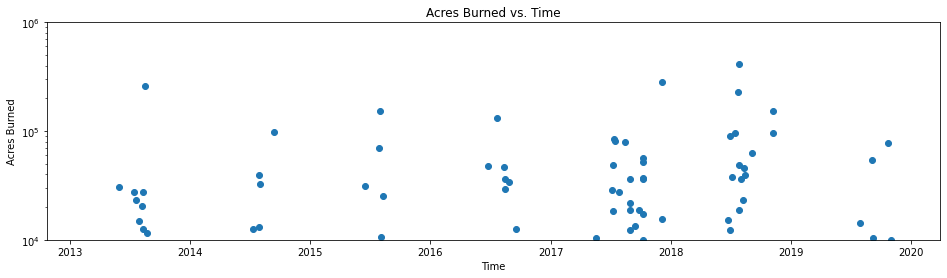

In [93]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(ca_fires_df['StartDate'], ca_fires_df['AcresBurned'])
ax.set_yscale('log')

ax.set_title('Acres Burned vs. Time')
ax.set_xlabel('Time')
ax.set_ylabel('Acres Burned')
ax.set_ylim(10**4, 10**6)

plt.show()

In [94]:
ca_fires_copy = ca_fires_df.copy()
ca_fires_copy.shape

(1410, 10)

In [95]:
ca_fires_copy['DateAsInt'] = ca_fires_df['StartDate'].apply(lambda x: int(str(x).replace('-', '')[:9]))
# changes date to integer, so I can calculate the correlation.

In [96]:
ca_fires_copy['DateAsInt'].corr(ca_fires_copy['AcresBurned'])

-0.017636715327419866

The correlation between the progression of time and the acres burned by each fire is -0.018. Since the correlation is roughly 0, we can conclude that there is basically no correlation between the two. There is not enough evidence to reject the null hypothesis. Therefore, the data does not show a trend between the acres affected by the California fires and the time period 2013-2019.

In [97]:
mi_lst = []
for year in year_lst:
    mi_lst.append(ca_fires_df[ca_fires_df['StartYear']==year]['MajorIncident'])

In [98]:
nk_dct = {}
for bool_lst in mi_lst:
    nk_dct[len(bool_lst)] = sum(bool_lst)

In [99]:
post_dist = []
for n, k in nk_dct.items():
    post_dist.append(stats.distributions.beta(a = 1 + k, b = 1 + n - k))

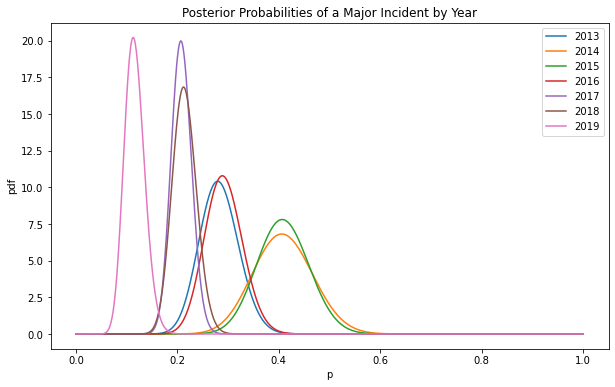

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.linspace(0,1,1000)
year_lst = [2013, 2014, 2015, 2016, 2017, 2018, 2019]
for idx, dist in enumerate(post_dist):
    ax.plot(x, dist.pdf(x), label=f'{year_lst[idx]}')
    ax.legend()
    ax.set_title('Posterior Probabilities of a Major Incident by Year')
    ax.set_xlabel('p')
    ax.set_ylabel('pdf')

In [102]:
beta_2013 = post_dist[0]
beta_2019 = post_dist[-1]

In [103]:
sim_2013 = beta_2013.rvs(size=10000)
sim_2019 = beta_2019.rvs(size=10000)

In [104]:
(sim_2019 > sim_2013).mean()

0.0001

There is a very low (basically 0%) chance that the probability that a fire is a major incident in 2019 is greater than that in 2013. Therefore, we can deduce that people's perception of how dangerous the fires are is going down.

In [105]:
beta_2013 = post_dist[0]
beta_2018 = post_dist[-2]
sim_2013 = beta_2013.rvs(size=10000)
sim_2018 = beta_2018.rvs(size=10000)
(sim_2018 > sim_2013).mean()

0.0596

Due to the fact that 2019 was an anomaly, I tested for the difference between 2013 and 2018. There is 6% chance that the probability that a fire is a major incident in 2018 is greater than that in 2013. This is still low, which would allow us to reach the same conclusion.

CONCLUSION

Observations:

2019 was known as an "anomaly" with heavy rains that were able to prevent fires from starting in California.
Even though the 'severity' (AcresBurned) could not be proven to be increasing, the number of fires is still increasing in California.
Over the past 6 years, fires have been causing more damage (AcresBurned) in the summer/fall time rather than the spring/summer time.
Now, people do not think of fires as major incidents as much as they did in 2013.

Thoughts for next time:

Increase the time period.
Have a column for temperature and test for a relationship.